<a href="https://colab.research.google.com/github/ivanmadan/Embed_activations_inGPT2/blob/main/Embedding_distance_in_activations_of_small_models_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Submission for Neel's stream, Mats summer 2024.
Set-up and other pieces were scrambled/adapted from arena's course


# Setup

In [ ]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"

if IN_COLAB:
    # Install packages
    %pip install transformer_lens
    %pip install einops
    %pip install jaxtyping
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists(f"/content/{chapter}"):
        !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
        !unzip /content/main.zip 'ARENA_3.0-main/chapter1_transformer_interp/exercises/*'
        sys.path.append(f"/content/{repo}-main/{chapter}/exercises")
        os.remove("/content/main.zip")
        os.rename(f"{repo}-main/{chapter}", chapter)
        os.rmdir(f"{repo}-main")
        os.chdir(f"{chapter}/exercises")
else:
    chapter_dir = r"./" if chapter in os.listdir() else os.getcwd().split(chapter)[0]
    sys.path.append(chapter_dir + f"{chapter}/exercises")

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-mw1j5kh9
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-mw1j5kh9
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
import sys
import plotly.express as px
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import einops
from jaxtyping import Int, Float
from typing import List, Optional, Tuple
import functools
from tqdm import tqdm
from IPython.display import display
import webbrowser
import gdown
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import circuitsvis as cv

import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

# Make sure exercises are in the path
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part2_intro_to_mech_interp").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, hist, plot_comp_scores, plot_logit_attribution, plot_loss_difference
from part1_transformer_from_scratch.solutions import get_log_probs
import part2_intro_to_mech_interp.tests as tests

# Saves computation time, since we don't need it for the contents of this notebook
t.set_grad_enabled(False)

device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == "__main__"

# Execution


## Loading and Running Models

we load first two models (gpt2_small and toy) to see if the code works at all


In [ ]:
gpt2_small: HookedTransformer = HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
cfg = HookedTransformerConfig(
    d_model=768,
    d_head=64,
    n_heads=12,
    n_layers=2,
    n_ctx=2048,
    d_vocab=50278,
    attention_dir="causal",
    attn_only=True, # defaults to False
    tokenizer_name="EleutherAI/gpt-neox-20b",
    seed=398,
    use_attn_result=True,
    normalization_type=None, # defaults to "LN", i.e. layernorm with weights & biases
    positional_embedding_type="shortformer"
)

In [ ]:
from huggingface_hub import hf_hub_download

REPO_ID = "callummcdougall/attn_only_2L_half"
FILENAME = "attn_only_2L_half.pth"

weights_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

In [ ]:
toy = HookedTransformer(cfg)
pretrained_weights = t.load(weights_path, map_location=device)
toy.load_state_dict(pretrained_weights)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<All keys matched successfully>

### prompts

In [ ]:
#flags
f_syn = 0 # 1 for syn 0 for ant
f_layer = "mlp" # "mlp" or "attn"


In [ ]:
if f_syn:
  text = ('Joe is a kind man, he treats everyone','Joe is a nice man, he treats everyone')
else:
  text = ('Joe is a kind man, he treats everyone','Joe is a mean man, he treats everyone')
model = gpt2_small
logits_0, cache_0 = model.run_with_cache(text[0], remove_batch_dim=True)
logits_1, cache_1 = model.run_with_cache(text[1], remove_batch_dim=True)

In [ ]:
residual_stream_0, labels_0 = cache_0.decompose_resid(return_labels=True)
residual_stream_1, labels_1 = cache_1.decompose_resid(return_labels=True)
if f_layer == "attn":
  indices = t.arange(2, residual_stream_0.size(0), 2)
  residual_stream_0 = residual_stream_0[indices]
  residual_stream_1 = residual_stream_1[indices]
  test = [labels_0[i] for i in indices]
elif f_layer == "mlp":
  indices = t.arange(3, residual_stream_0.size(0), 2)
  residual_stream_0 = residual_stream_0[indices]
  residual_stream_1 = residual_stream_1[indices]
  test = [labels_0[i] for i in indices]
print(test)
res_0_soft = residual_stream_0.softmax(dim=-1)
res_1_soft = residual_stream_1.softmax(dim=-1)
print(residual_stream_0.shape,res_0_soft.shape)

['0_mlp_out', '1_mlp_out', '2_mlp_out', '3_mlp_out', '4_mlp_out', '5_mlp_out', '6_mlp_out', '7_mlp_out', '8_mlp_out', '9_mlp_out', '10_mlp_out', '11_mlp_out']
torch.Size([12, 10, 768]) torch.Size([12, 10, 768])


*I've spent some time trying to find how to visualize mlp with sv before understanding that this is not in the documentation.
I think I still would like to look at the mlp pre and post

### Entropy
 Let's calcualte entropy of residual stream differences. I probably should softmax before subtracting the two residual streams

We calculate entropy before subtraction for future normalization purposes (maybe)

In [ ]:
# Assuming res_0_soft is your tensor
valid_probs = (res_0_soft >= 0) & (res_0_soft <= 1)

# Check if all elements are valid
all_valid = valid_probs.all()
print("All elements are valid probabilities:", all_valid.item())

if not all_valid:
    print("Invalid values detected.")
    print("Values less than 0:", (res_0_soft < 0).sum().item())
    print("Values greater than 1:", (res_0_soft > 1).sum().item())

All elements are valid probabilities: True


In [ ]:
entropy_0 = -(res_0_soft * t.log(res_0_soft+1e-5)).sum(dim=-1)
entropy_1 = -(res_1_soft * t.log(res_1_soft+1e-5)).sum(dim=-1)

In [ ]:
#plt.figure(figsize=(30, 3))
#plt.imshow(entropy_0.cpu(),aspect='auto', cmap='viridis', interpolation = 'none')
#plt.colorbar()
#plt.figure(figsize=(30, 3))
#plt.imshow(entropy_0.cpu()-entropy_1.cpu(),aspect='auto', cmap='viridis', interpolation = 'none')
#plt.colorbar()

In [ ]:
dif_stream = residual_stream_0-residual_stream_1
dif_stream_soft = dif_stream.softmax(dim=-1)
entropy_dif_stream_soft = -(dif_stream_soft * t.log(dif_stream_soft+1e-5)).sum(dim=-1)

Text(0, 0.5, 'layer')

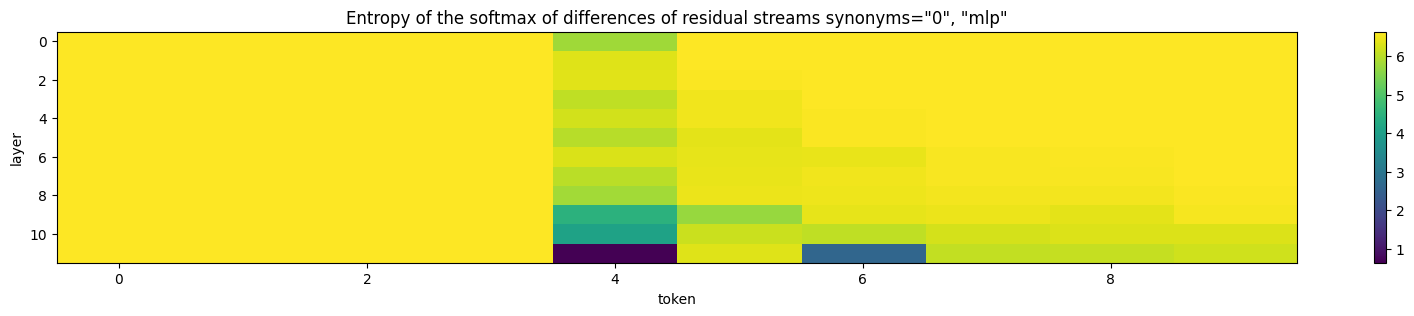

In [ ]:
plt.figure(figsize=(20, 3))
plt.imshow(entropy_dif_stream_soft.cpu(),aspect='auto', cmap='viridis', interpolation = 'none')
plt.colorbar()
plt.title(f'Entropy of the softmax of differences of residual streams synonyms="{f_syn}", "{f_layer}"')
plt.xlabel('token')
plt.ylabel('layer')

### Variance

In [ ]:
dif = (res_0_soft-res_1_soft)
dif_var = dif.var(dim=-1)
entropy_dif = -(dif * t.log(abs(dif)+1e-5)).sum(dim=-1) # note that this is cheeky entropy because I take absolute values to avoid

Text(0, 0.5, 'layer')

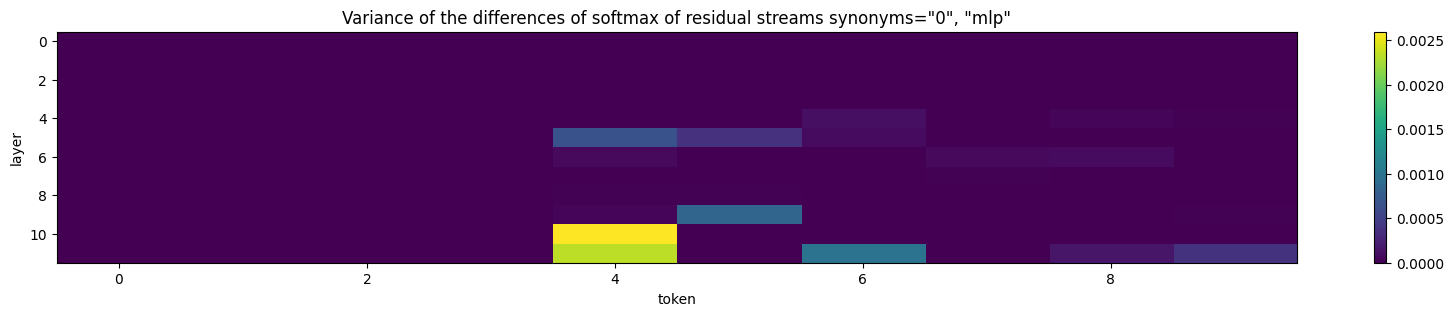

In [ ]:
plt.figure(figsize=(20, 3))
plt.imshow(dif_var.cpu(),aspect='auto', cmap='viridis', interpolation = 'none')
plt.colorbar()
plt.title(f'Variance of the differences of softmax of residual streams synonyms="{f_syn}", "{f_layer}"')
plt.xlabel('token')
plt.ylabel('layer')

### Cosine similarity

Let's move to the scalar product of residual streams (I have some horror inside of me due to the ghost of superposition).

Text(0, 0.5, 'layer')

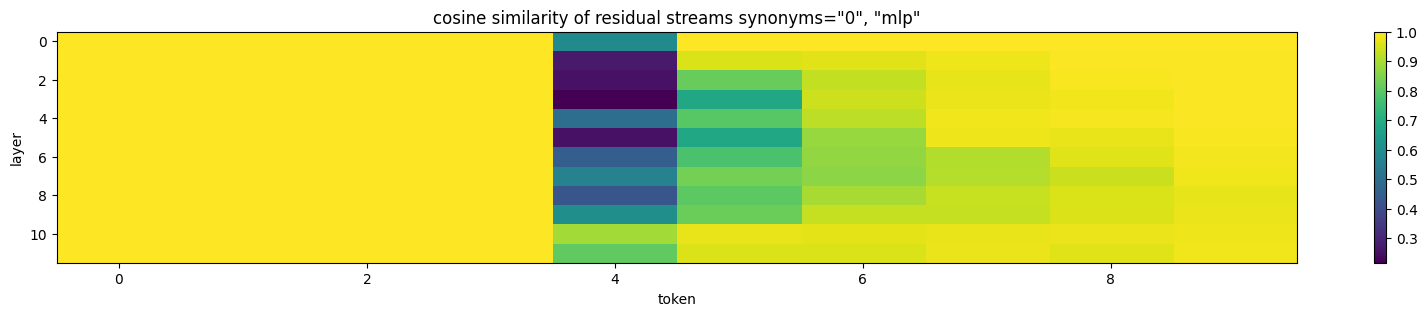

In [ ]:
#res_product = (res_0_soft*res_1_soft).sqrt()
res_product = t.nn.functional.cosine_similarity(residual_stream_0,residual_stream_1,dim=-1)

res_product_sum = res_product.sum(dim=-1)
plt.figure(figsize=(20, 3))
plt.imshow(res_product.cpu(),aspect='auto', cmap='viridis', interpolation = 'none')
plt.colorbar()
plt.title(f'cosine similarity of residual streams synonyms="{f_syn}", "{f_layer}"')
plt.xlabel('token')
plt.ylabel('layer')


## Multiple prompts


Let's test several synonym/antonym pairs. Let see if the entropy in the last layer output is consistently low at the original token position for synonyms and high for antonyms and is consistently low for the last token position for anotonyms

In [ ]:
# List of adjectives
adjectives = [
    ('kind', 'nice', 'mean'),
    ('smart', 'wise', 'dim'),
    ('strong', 'bold', 'weak'),
    ('true', 'real', 'fake'),
    ('fair', 'just', 'mean'),
    ('still', 'cool', 'mad'),
    ('rich', 'flush', 'poor'),
    ('true', 'real', 'fake'),
    ('hard', 'solid', 'soft'),
    ('fast', 'quick', 'slow'),
]

#check if they are no more than one token
for tup in adjectives:
  for idx in range(3):
    if len(gpt2_small.to_str_tokens(tup[idx]))>2:
      print(tup, idx, "too long")


In [ ]:
f_layer = "attn"
f_syn = 0
tensors_list = []

for tup in adjectives:

  if f_syn:
    text = (f'Joe is a {tup[0]} man, he treats everyone',f'Joe is a {tup[1]} man, he treats everyone')
  else:
    text = (f'Joe is a {tup[0]} man, he treats everyone',f'Joe is a {tup[2]} man, he treats everyone')
  logits_0, cache_0 = model.run_with_cache(text[0], remove_batch_dim=True)
  logits_1, cache_1 = model.run_with_cache(text[1], remove_batch_dim=True)

  residual_stream_0, labels_0 = cache_0.decompose_resid(return_labels=True)
  residual_stream_1, labels_1 = cache_1.decompose_resid(return_labels=True)
  if f_layer == "attn":
    indices = t.arange(2, residual_stream_0.size(0), 2)
    residual_stream_0 = residual_stream_0[indices]
    residual_stream_1 = residual_stream_1[indices]
    test = [labels_0[i] for i in indices]
    test1 = [labels_1[i] for i in indices]
  elif f_layer == "mlp":
    indices = t.arange(3, residual_stream_0.size(0), 2)
    residual_stream_0 = residual_stream_0[indices]
    residual_stream_1 = residual_stream_1[indices]
    test = [labels_0[i] for i in indices]
    test1 = [labels_1[i] for i in indices]

      #res_0_soft = residual_stream_0.softmax(dim=-1)
      #res_1_soft = residual_stream_1.softmax(dim=-1)

  dif_stream = residual_stream_0-residual_stream_1
  dif_stream_soft = dif_stream.softmax(dim=-1)
  entropy_dif_stream_soft = -(dif_stream_soft * t.log(dif_stream_soft+1e-5)).sum(dim=-1)
  tensors_list.append(entropy_dif_stream_soft[-1,:])
      #print(entropy_dif_stream_soft[-1,:])

entropy_list = t.stack(tensors_list)
print(entropy_list.shape)

torch.Size([10, 10])


Text(0, 0.5, 'token tuple')

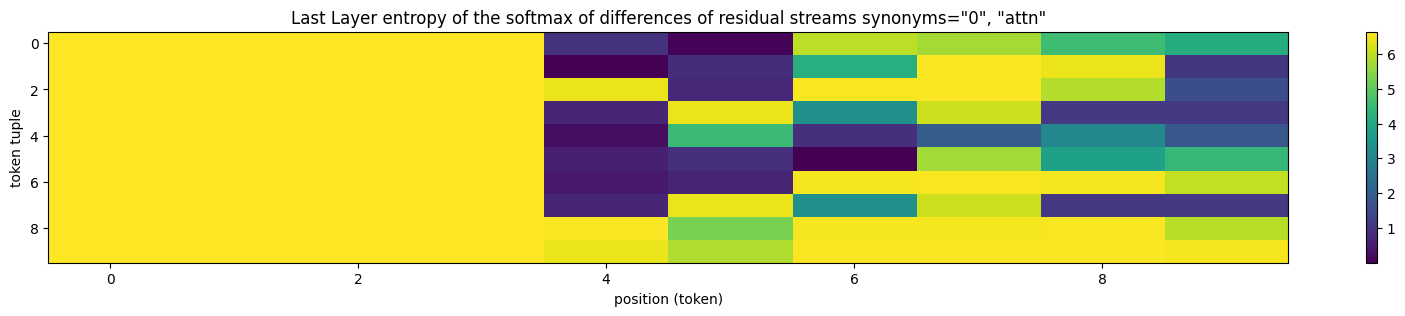

In [ ]:
plt.figure(figsize=(20, 3))
plt.imshow(entropy_list.cpu(),aspect='auto', cmap='viridis', interpolation = 'none')
plt.colorbar()
plt.title(f'Last Layer entropy of the softmax of differences of residual streams synonyms="{f_syn}", "{f_layer}"')
plt.xlabel('position (token)')
plt.ylabel('token tuple')

## Attention heads of the last layer

In [ ]:
f_syn = 0
adjectives = [
    ('kind', 'nice', 'mean'),
    ('smart', 'wise', 'dim'),
    ('strong', 'bold', 'weak'),
    ('true', 'real', 'fake'),
    ('fair', 'just', 'mean'),
    ('still', 'cool', 'mad'),
    ('rich', 'flush', 'poor'),
    ('true', 'real', 'fake'),
    ('hard', 'solid', 'soft'),
    ('fast', 'quick', 'slow'),
]
sub_adjectives = [adjectives[0]]
print(sub_adjectives)
for tup in sub_adjectives:

  if f_syn:
    text = (f'Joe is a {tup[0]} man, he treats everyone',f'Joe is a {tup[1]} man, he treats everyone')
  else:
    text = (f'Joe is a {tup[0]} man, he treats everyone',f'Joe is a {tup[2]} man, he treats everyone')
  logits_0, cache_0 = model.run_with_cache(text[0], remove_batch_dim=True)
  logits_1, cache_1 = model.run_with_cache(text[1], remove_batch_dim=True)

[('kind', 'nice', 'mean')]


In [ ]:
str_tokens = model.to_str_tokens(text[0])
attention_pattern = cache_0["pattern", 10]
display(cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern))
str_tokens = model.to_str_tokens(text[1])
attention_pattern = cache_1["pattern", 10]
display(cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern))

In [ ]:
str_tokens = model.to_str_tokens(text[0])
for layer in range(model.cfg.n_layers):
    attention_pattern = cache_0["pattern", layer]
    display(cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern))